In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

In [2]:
# list all the folders in the root_path folder

root_path = os.path.dirname(os.path.abspath("")) + "\\data\\people\\"

people_paths = []
for folder in os.listdir(root_path):
    if os.path.isdir(os.path.join(root_path, folder)):
        people_paths.append(os.path.join(root_path, folder))

print('\n'.join(people_paths))

c:\Users\echriston\Documents\stage_2024_nao\robot-speech-to-speech\data\people\unknown
c:\Users\echriston\Documents\stage_2024_nao\robot-speech-to-speech\data\people\unknown_1
c:\Users\echriston\Documents\stage_2024_nao\robot-speech-to-speech\data\people\unknown_2
c:\Users\echriston\Documents\stage_2024_nao\robot-speech-to-speech\data\people\unknown_3
c:\Users\echriston\Documents\stage_2024_nao\robot-speech-to-speech\data\people\unknown_4
c:\Users\echriston\Documents\stage_2024_nao\robot-speech-to-speech\data\people\unknown_5
c:\Users\echriston\Documents\stage_2024_nao\robot-speech-to-speech\data\people\unknown_6
c:\Users\echriston\Documents\stage_2024_nao\robot-speech-to-speech\data\people\unknown_7


In [3]:
face_info_files = []
for path in people_paths:
    for file in os.listdir(path):
        if file.endswith(".csv"):
            face_info_files.append(os.path.join(path, file))

print('\n'.join(face_info_files))

c:\Users\echriston\Documents\stage_2024_nao\robot-speech-to-speech\data\people\unknown\face_info.csv
c:\Users\echriston\Documents\stage_2024_nao\robot-speech-to-speech\data\people\unknown_1\face_info.csv
c:\Users\echriston\Documents\stage_2024_nao\robot-speech-to-speech\data\people\unknown_2\face_info.csv
c:\Users\echriston\Documents\stage_2024_nao\robot-speech-to-speech\data\people\unknown_3\face_info.csv
c:\Users\echriston\Documents\stage_2024_nao\robot-speech-to-speech\data\people\unknown_4\face_info.csv
c:\Users\echriston\Documents\stage_2024_nao\robot-speech-to-speech\data\people\unknown_5\face_info.csv
c:\Users\echriston\Documents\stage_2024_nao\robot-speech-to-speech\data\people\unknown_6\face_info.csv
c:\Users\echriston\Documents\stage_2024_nao\robot-speech-to-speech\data\people\unknown_7\face_info.csv


In [4]:
# explore the first file
df = pd.read_csv(face_info_files[0])

print(df.columns)

# ['timeStamp', 'faceID', 'scoreReco', 'faceLabel', 'shapeInfo_alpha',
# 'shapeInfo_beta', 'shapeInfo_width', 'shapeInfo_height',
# 'leftEye_center_x', 'leftEye_center_y', 'leftEye_nose_limit_x',
# 'leftEye_nose_limit_y', 'leftEye_ear_limit_x', 'leftEye_ear_limit_y',
# 'rightEye_center_x', 'rightEye_center_y', 'rightEye_nose_limit_x',
# 'rightEye_nose_limit_y', 'rightEye_ear_limit_x', 'rightEye_ear_limit_y',
# 'nose_center_x', 'nose_center_y', 'nose_left_limit_x',
# 'nose_left_limit_y', 'nose_right_limit_x', 'nose_right_limit_y',
# 'mouth_left_limit_x', 'mouth_left_limit_y', 'mouth_right_limit_x',
# 'mouth_right_limit_y', 'mouth_top_limit_x', 'mouth_top_limit_y']

Index(['timeStamp', 'faceID', 'scoreReco', 'faceLabel', 'shapeInfo_alpha',
       'shapeInfo_beta', 'shapeInfo_width', 'shapeInfo_height',
       'leftEye_center_x', 'leftEye_center_y', 'leftEye_nose_limit_x',
       'leftEye_nose_limit_y', 'leftEye_ear_limit_x', 'leftEye_ear_limit_y',
       'rightEye_center_x', 'rightEye_center_y', 'rightEye_nose_limit_x',
       'rightEye_nose_limit_y', 'rightEye_ear_limit_x', 'rightEye_ear_limit_y',
       'nose_center_x', 'nose_center_y', 'nose_left_limit_x',
       'nose_left_limit_y', 'nose_right_limit_x', 'nose_right_limit_y',
       'mouth_left_limit_x', 'mouth_left_limit_y', 'mouth_right_limit_x',
       'mouth_right_limit_y', 'mouth_top_limit_x', 'mouth_top_limit_y'],
      dtype='object')


In [5]:
def align_on_shape(raw):
    # for each row, the point alpha, beta must be the center of the face (0, 0)
    # and the width and height must be 2 so everything is normalized between -1 and 1
    alpha = raw["shapeInfo_alpha"]
    beta = raw["shapeInfo_beta"]
    width = raw["shapeInfo_width"]
    height = raw["shapeInfo_height"]

    for i in range(4, len(raw)):
        if i%2 == 0:
            raw[i] = (raw[i] - alpha) / width
        else:
            raw[i] = (raw[i] - beta) / height

    return raw

def align_on_nose(raw):
    # for each row, the point nose_center_x, nose_center_y must be the center of the face (0, 0)

    nose_center_x = raw["nose_center_x"]
    nose_center_y = raw["nose_center_y"]

    for i in range(4, len(raw)):
        if i%2 == 0:
            raw[i] = raw[i] - nose_center_x
        else:
            raw[i] = raw[i] - nose_center_y
    
    raw["nose_center_x"] = 0
    raw["nose_center_y"] = 0

    return raw


def dist_between_points(x1, y1, x2, y2):
    return ((x2 - x1)**2 + (y2 - y1)**2)**0.5


def align_on_nose_and_eyes(raw):
    # the nose is the center (0, 0)
    # the center of the two eyes are at (0, -0.5)


    # translation so the nose is at (0, 0)
    nose_center = [raw["nose_center_x"], raw["nose_center_y"]]

    for i in range(4, len(raw)):
        if i%2 == 0:
            raw[i] = raw[i] - nose_center[0]
        else:
            raw[i] = raw[i] - nose_center[1]

    # rotation so the center of the two eyes are at (0, ?)
    eyes_center = [(raw["leftEye_center_x"] + raw["rightEye_center_x"]) / 2, (raw["leftEye_center_y"] + raw["rightEye_center_y"]) / 2]

    # angle between the line (0, 0) -> (eyes_center[0], eyes_center[1]) and the y axis
    if eyes_center[0] != 0:
        angle = np.arctan(eyes_center[0] / eyes_center[1])

        for i in range(8, len(raw), 2):
            raw[i] = raw[i] * np.cos(angle) - raw[i+1] * np.sin(angle)
            raw[i+1] = raw[i] * np.sin(angle) + raw[i+1] * np.cos(angle)

    # scaling so the distance between the two eyes is 1 and the distance between the nose and the eyes is 0.5
    eyes_center = [(raw["leftEye_center_x"] + raw["rightEye_center_x"]) / 2, (raw["leftEye_center_y"] + raw["rightEye_center_y"]) / 2]
    eyes_dist = dist_between_points(raw["leftEye_center_x"], raw["leftEye_center_y"], raw["rightEye_center_x"], raw["rightEye_center_y"])
    nose_eyes_dist = dist_between_points(eyes_center[0], eyes_center[1], 0, 0)

    if eyes_dist == 0:
        eyes_dist = 1
    if nose_eyes_dist == 0:
        nose_eyes_dist = 1

    for i in range(4, len(raw)):
        if i%2 == 0:
            raw[i] = raw[i] / eyes_dist
        else:
            raw[i] = raw[i] / (nose_eyes_dist / 0.5)

    return raw


def normalize_df(df):
    # make all the values between -1 and 1 per column
    res = df.copy()
    for col in df.columns:
        if df[col].dtype == np.float64 or df[col].dtype == np.int64 or df[col].dtype == np.float32 or df[col].dtype == np.int32:
            if (df[col].max() - df[col].min()) == 0:
                continue
            res[col] = df[col].apply(lambda x: ( (x - df[col].min()) / (df[col].max() - df[col].min()) ) * 2 - 1)
        else:
            print(f"Column {col} is not a number, it will not be normalized")
    return res


def drop_useless_raws(df):
    # drop the raws where the left_eye_center_x is 0
    df = df[df.leftEye_center_x != 0]
    # drop the raws where the mouth_top_limit_x is above 1 or below -1
    df = df[df.mouth_top_limit_x < 1]
    df = df[df.mouth_top_limit_x > -1]
    return df
    
def get_mean_df(df):
    # return the mean of the dataframe
    # for non numeric columns, return the first value
    mean = {}
    for col in df.columns:
        if df[col].dtype == np.float64 or df[col].dtype == np.int64 or df[col].dtype == np.float32 or df[col].dtype == np.int32:
            mean[col] = df[col].mean()
        else:
            mean[col] = df[col].iloc[0]
    # build a dataframe with the mean
    mean_df = pd.DataFrame(mean, index=[0])
    return mean_df


def get_median_df(df):
    # return the median of the dataframe
    # for non numeric columns, return the first value
    median = {}
    for col in df.columns:
        if df[col].dtype == np.float64 or df[col].dtype == np.int64 or df[col].dtype == np.float32 or df[col].dtype == np.int32:
            median[col] = df[col].median()
        else:
            median[col] = df[col].iloc[0]
    # build a dataframe with the median
    median_df = pd.DataFrame(median, index=[0])
    return median_df

def get_segment_df(df):
    # return the segment of the dataframe
    res = pd.DataFrame()
    # compute the distance between each face point and add it to the dataframe
    for i in range(8, len(df.columns), 2):
        for j in range(i, len(df.columns), 2):
            res[f"dist_{df.columns[i]}_and_{df.columns[j]}"] = df.apply(lambda x: dist_between_points(x[i], x[i+1], x[j], x[j+1]), axis=1)
    # the 
    return res


In [6]:
# plot the coordinates of the face

def plot_face(df):
    plt.figure()

    plt.plot(df["leftEye_center_x"], df["leftEye_center_y"], 'ro')
    plt.plot(df["rightEye_center_x"], df["rightEye_center_y"], 'ro')
    plt.plot((df["leftEye_center_x"] + df["rightEye_center_x"]) / 2, (df["leftEye_center_y"] + df["rightEye_center_y"]) / 2, 'r+')
    plt.plot(df["nose_center_x"], df["nose_center_y"], 'bo')
    plt.plot(df["mouth_left_limit_x"], df["mouth_left_limit_y"], 'ko')
    plt.plot(df["mouth_right_limit_x"], df["mouth_right_limit_y"], 'ko')
    plt.plot(df["mouth_top_limit_x"], df["mouth_top_limit_y"], 'go')

    # invert y axis
    plt.gca().invert_yaxis()

    plt.show()

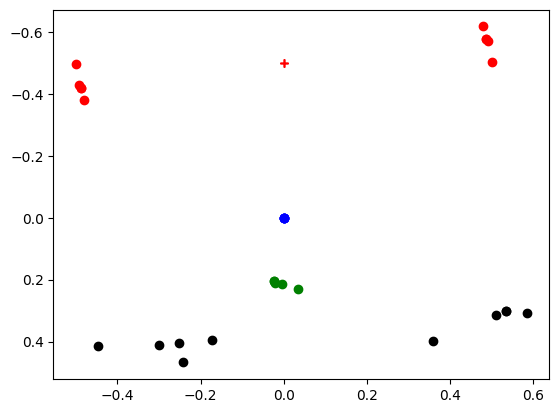

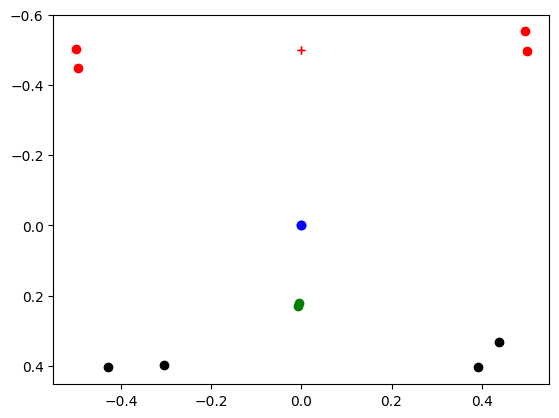

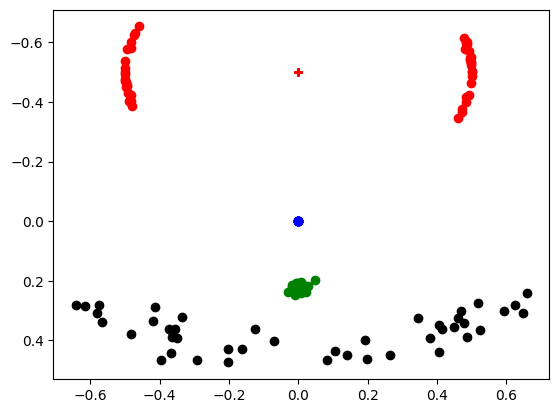

In [7]:
for df_path in face_info_files[-3:]:

    df = pd.read_csv(df_path)
    df = df.apply(align_on_nose_and_eyes, axis=1)
    df = drop_useless_raws(df)
    plot_face(df)

In [8]:
big_df = pd.DataFrame()
for df_path in face_info_files:
    df = pd.read_csv(df_path)
    df = df.apply(align_on_nose_and_eyes, axis=1)
    df = drop_useless_raws(df)
    # df sumerized is the first raw for non numerical columns and the mean for numerical columns
    # df = get_mean_df(df)
    big_df = pd.concat([big_df, df], ignore_index=True)

big_df = normalize_df(big_df)


Column timeStamp is not a number, it will not be normalized


In [9]:
print(big_df.drop(columns=["timeStamp", "faceID", "faceLabel", "scoreReco"]))

    shapeInfo_alpha  shapeInfo_beta  shapeInfo_width  shapeInfo_height  \
0          0.211763        0.183528         0.253026         -0.042381   
1         -0.023895        0.193953         0.124765          0.030592   
2         -0.024152        0.106689         0.180194          0.043395   
3          0.026886       -0.019273         0.112713          0.043395   
4          0.131721       -0.019273         0.118620          0.043395   
..              ...             ...              ...               ...   
67        -0.506106        0.030219        -0.820515         -0.173270   
68        -0.557072       -0.048971        -0.711620         -0.167858   
69        -0.557072        0.085675        -0.642247         -0.154111   
70        -0.684011       -0.132894        -0.719176         -0.404952   
71        -0.602393       -0.147197        -0.541977          0.287434   

    leftEye_center_x  leftEye_center_y  leftEye_nose_limit_x  \
0           0.885402         -0.172496         

cluster 0 size 48
[1151, 635839]
   [1152, 135579]
   [1152, 635329]
   [1153, 135069]
   [1153, 634829]
   [1154, 134553]
   [1154, 634296]
   [1155, 134039]
   [1155, 633780]
   [1156, 133520]
   [1156, 633273]
   [1157, 133025]
   [1157, 632750]
   [1158, 132496]
   [1510, 50257]
   [1510, 549997]
   [1511, 549471]
   [1512, 49227]
   [1512, 548954]
   [1513, 48691]
   [1513, 548440]
   [1516, 546871]
   [1600, 603163]
   [1601, 569329]
   [1602, 102388]
   [1603, 68546]
   [1604, 567765]
   [1606, 66997]
   [1609, 565179]
   [1723, 206024]
   [1724, 205506]
   [1726, 670908]
   [161, 755894]
   [162, 255635]
   [162, 755371]
   [165, 254073]
   [2665, 58280]
   [4288, 958600]
   [4289, 458328]
   [4289, 958068]
   [4291, 457283]
   [4292, 956482]
   [4293, 456222]
   [4295, 954898]
   [4296, 454640]
   [4296, 987687]
   [4298, 953313]
   [4299, 453051]
cluster 1 size 15
[1160, 131462]
   [1511, 49739]
   [1546, 231442]
   [1589, 75828]
   [1590, 41987]
   [1590, 575041]
   [1591, 5

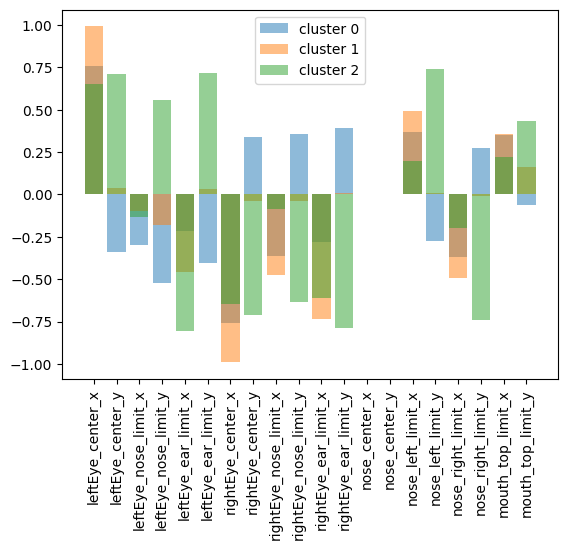

In [12]:
# let's do a clustering

dropped_columns = ["timeStamp", "faceID", "faceLabel", "scoreReco", "shapeInfo_alpha", "shapeInfo_beta", "shapeInfo_width", "shapeInfo_height", "mouth_left_limit_x", "mouth_left_limit_y", "mouth_right_limit_x", "mouth_right_limit_y"]

clustering = KMeans(n_clusters=3).fit(big_df.drop(columns=dropped_columns))
# cut the data into the clusters
big_df["cluster"] = clustering.labels_

# for each cluster, plot the face

plt.figure()


for cluster in big_df["cluster"].unique():
    df = big_df[big_df["cluster"] == cluster]
    print("cluster", cluster, "size", len(df))
    print('\n   '.join(df["timeStamp"]))

    # plot the main differences between the two clusters
    plt.bar(df.drop(columns=dropped_columns + ["cluster"]).columns, df.drop(columns=dropped_columns + ["cluster"]).mean(), label="cluster " + str(cluster), alpha=0.5)

# x axis labels in vertical
plt.xticks(rotation=90)
plt.legend()
plt.show()
    